In [27]:
import io,os
import requests
import datetime
import warnings
import winsound
import itertools
import matplotlib
import statistics 
import scipy.stats
%matplotlib inline
import talib as ta
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import cufflinks as cf
from pathlib import Path
from pylab import rcParams
from sklearn.svm import SVC
from matplotlib import dates
import matplotlib.pyplot as plt
from plotly.offline import iplot
from sklearn import mixture as mix
from colorama import Fore, Back, Style 
from sklearn.preprocessing import StandardScaler
num=int(input('Enter The number of your ticker ? '))
df=[]
curr=[]
print('Valid timeframe: 1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo')
timeframe=str(input('Enter The timeframe :'))
#----------------------------------------------------------------
print('Start: start date string (YYYY-MM-DD) or _datetime. Default is 1900-01-01')
start=pd.to_datetime(input('Enter The start date :')) 
#----------------------------------------------------------------
print('End: end date string (YYYY-MM-DD) or _datetime. Default is now') 
end=pd.to_datetime(input('Enter The end date :'))
#----------------------------------------------------------------
for i in range(num):
#---------------------------------------------------------------
    print('tickers : List of tickers: USDCAD, EURUSD, XAUUSD, ...')
    ticker=str(input('Enter The Name of your ticker ? ').upper())
    curr.append(ticker)    
    #----------------------------------------------------------------
    df.append(yf.download(tickers = ticker, interval = timeframe, start=start, end=end)['Close'])
    #----------------------------------------------------------------
df=pd.DataFrame(df).T
df.columns=curr
df.head()

Enter The number of your ticker ? 5
Valid timeframe: 1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo
Enter The timeframe :1d
Start: start date string (YYYY-MM-DD) or _datetime. Default is 1900-01-01
Enter The start date :2010
End: end date string (YYYY-MM-DD) or _datetime. Default is now
Enter The end date :now
tickers : List of tickers: USDCAD, EURUSD, XAUUSD, ...
Enter The Name of your ticker ? amzn
[*********************100%***********************]  1 of 1 completed
tickers : List of tickers: USDCAD, EURUSD, XAUUSD, ...
Enter The Name of your ticker ? aapl
[*********************100%***********************]  1 of 1 completed
tickers : List of tickers: USDCAD, EURUSD, XAUUSD, ...
Enter The Name of your ticker ? ge
[*********************100%***********************]  1 of 1 completed
tickers : List of tickers: USDCAD, EURUSD, XAUUSD, ...
Enter The Name of your ticker ? ^vix
[*********************100%***********************]  1 of 1 completed
tickers : List of tickers: USDCAD, 

,AMZN,AAPL,GE,^VIX,^GSPC
Date,,,,,
2010-01-04,133.899994,7.643214,118.846153,20.040001,1132.989990
2010-01-05,134.690002,7.656429,119.461540,19.350000,1136.520020
2010-01-06,132.250000,7.534643,118.846153,19.160000,1137.140015
2010-01-07,130.000000,7.520714,125.000000,19.059999,1141.689941
2010-01-08,133.520004,7.570714,127.692307,18.129999,1144.979980


# Daily Returns 

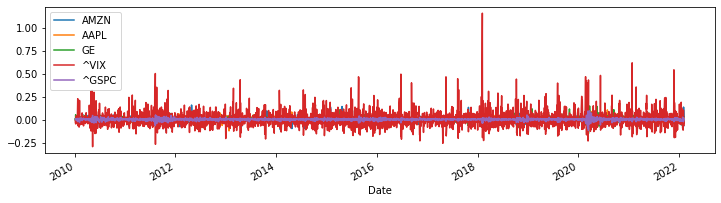

In [28]:
returns=df.pct_change(1).dropna()
returns.plot(figsize=(12,3));

# Cumulative Returns

In [29]:
cum_returns=((1+returns).cumprod()-1)*100
cum_return_final=pd.DataFrame(cum_returns.iloc[-1])
cum_return_final.columns=['Returns %']
cum_return_final=cum_return_final.transpose()
cum_return_final

,AMZN,AAPL,GE,^VIX,^GSPC
Returns %,2310.956062,2187.388482,-16.438189,6.986026,299.080317


# Sort the Returns

Maximum Return ==> AMZN : 2310 %


,AMZN,AAPL,^GSPC,^VIX,GE
% Returns,2310.956062,2187.388482,299.080317,6.986026,-16.438189


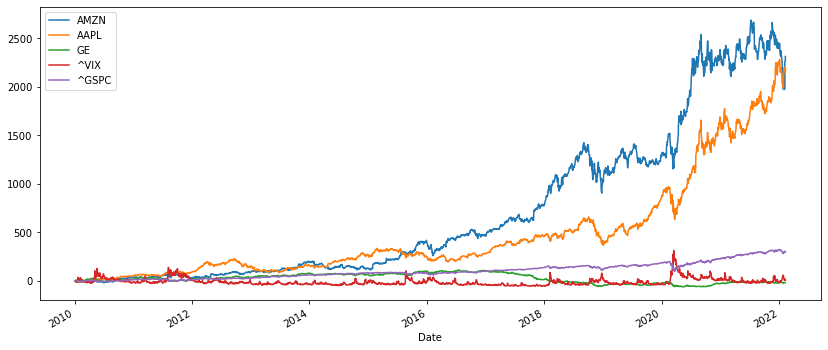

In [30]:
sorted_returns=cum_returns.tail(1).sort_values(by=cum_returns.index[-1], axis=1, ascending=False)
sorted_returns.index=['% Returns']
max_return=sorted_returns.columns[0]
min_return=sorted_returns.columns[-1]
print('Maximum Return ==>', max_return.split('-')[0], ':', int(sorted_returns[max_return].values), '%')
cum_returns.plot(figsize=(14,6))
sorted_returns

# 1. Equally Returns

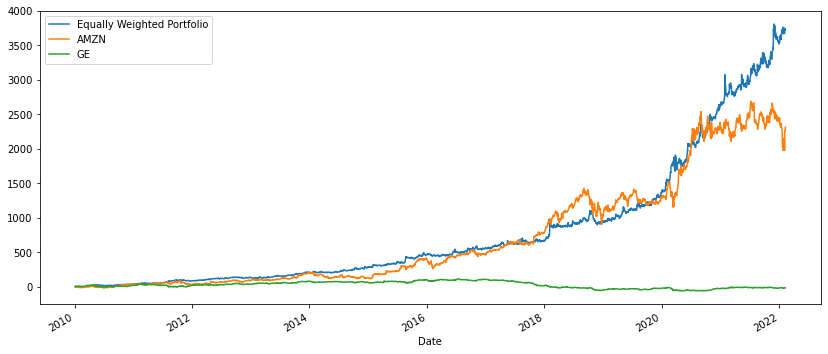

In [31]:
N=len(df.columns)
weights=N*[1/N]
equal_returns=np.dot(weights, returns.transpose())
cum_equal_returns=((1+equal_returns).cumprod()-1)*100
cum_equal_returns=pd.Series(cum_equal_returns, index=returns.index)
#----------------------------------------------------------------------
plt.figure(figsize=(14,6))
cum_equal_returns.plot(label='Equally Weighted Portfolio')
cum_returns[max_return].plot()
cum_returns[min_return].plot()
plt.legend();

# 2. Custom Weighted Portfolio

                  AMZN         AAPL       ^GSPC      ^VIX         GE
% Returns  2310.956062  2187.388482  299.080317  6.986026 -16.438189
Enter the Weight for each one !
0  %
AMZN50
50.0  %
AAPL30
80.0  %
GE20
100.0  %
^VIX0
100.0  %
^GSPC0


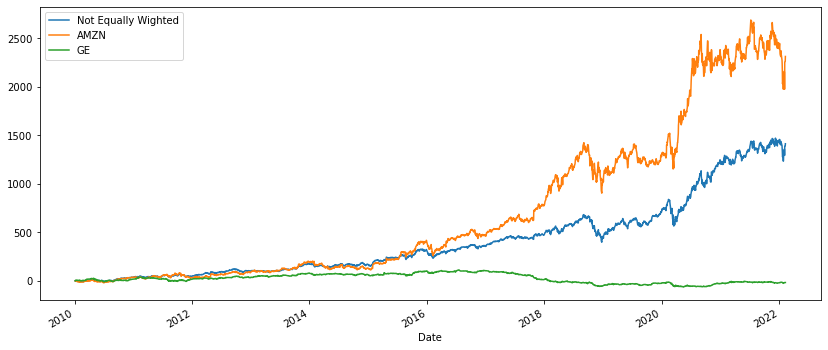

In [32]:
weights=[]
print(sorted_returns)
print ('Enter the Weight for each one !')
for i in range(num):
    print(np.round(sum(weights*100)), ' %')
    weights.append(float(input(returns.columns[i]))/100)
if sum(weights)!=1:
    print('!!!!!! Your weight summation is not equal to 100 % !!!!!!!!')
#-----------------------------------------------------------
notequal_returns=np.dot(weights, returns.transpose())
pd.DataFrame(notequal_returns)
cum_notequal_returns=((1+notequal_returns).cumprod()-1)*100
cum_notequal_returns=pd.Series(cum_notequal_returns, index=returns.index)
#------------------------------------------------------------
plt.figure(figsize=(14,6))
cum_notequal_returns.plot(label='Not Equally Wighted')
cum_returns[max_return].plot()
cum_returns[min_return].plot()
plt.legend();

# 3. Monte Carlo Simulation (Random Wights - Makowitz Bullet)

In [33]:
#Weight Generation function---------------------------------------------------------
def gen_weights(N):
    weights=np.random.random(N)
    return weights/np.sum(weights)

#Return Calculation function--------------------------------------------------------
def calc_returns(weights, log_rets):
    return np.sum(log_rets.mean()*weights) * 252

#Volatility Calculation function-----------------------------------------------------
def calc_volatility (weights, log_returns_cov):
    annulized_cov=np.dot(log_returns_cov*252, weights)
    vol=np.dot(weights.transpose(), annulized_cov)
    return np.sqrt(vol)

In [34]:
weights=gen_weights(num)
log_returns=np.log(df/df.shift(1))
log_returns_cov=log_returns.cov()

In [35]:
#Random weights generation and simulation
mc_weights=[]
mc_portfolio_returns=[]
mc_portfolio_vol=[]
#Simulation-----------------------------------------------------------
for sim in range (3000):
    weights=gen_weights(num)
    mc_weights.append(weights)
    mc_portfolio_returns.append(calc_returns(weights, log_returns))
    mc_portfolio_vol.append(calc_volatility(weights, log_returns_cov))

In [36]:
#Sharpe Ratio-----------------------------------------------------------
mc_sharpe=np.array(mc_portfolio_returns)/np.array(mc_portfolio_vol)

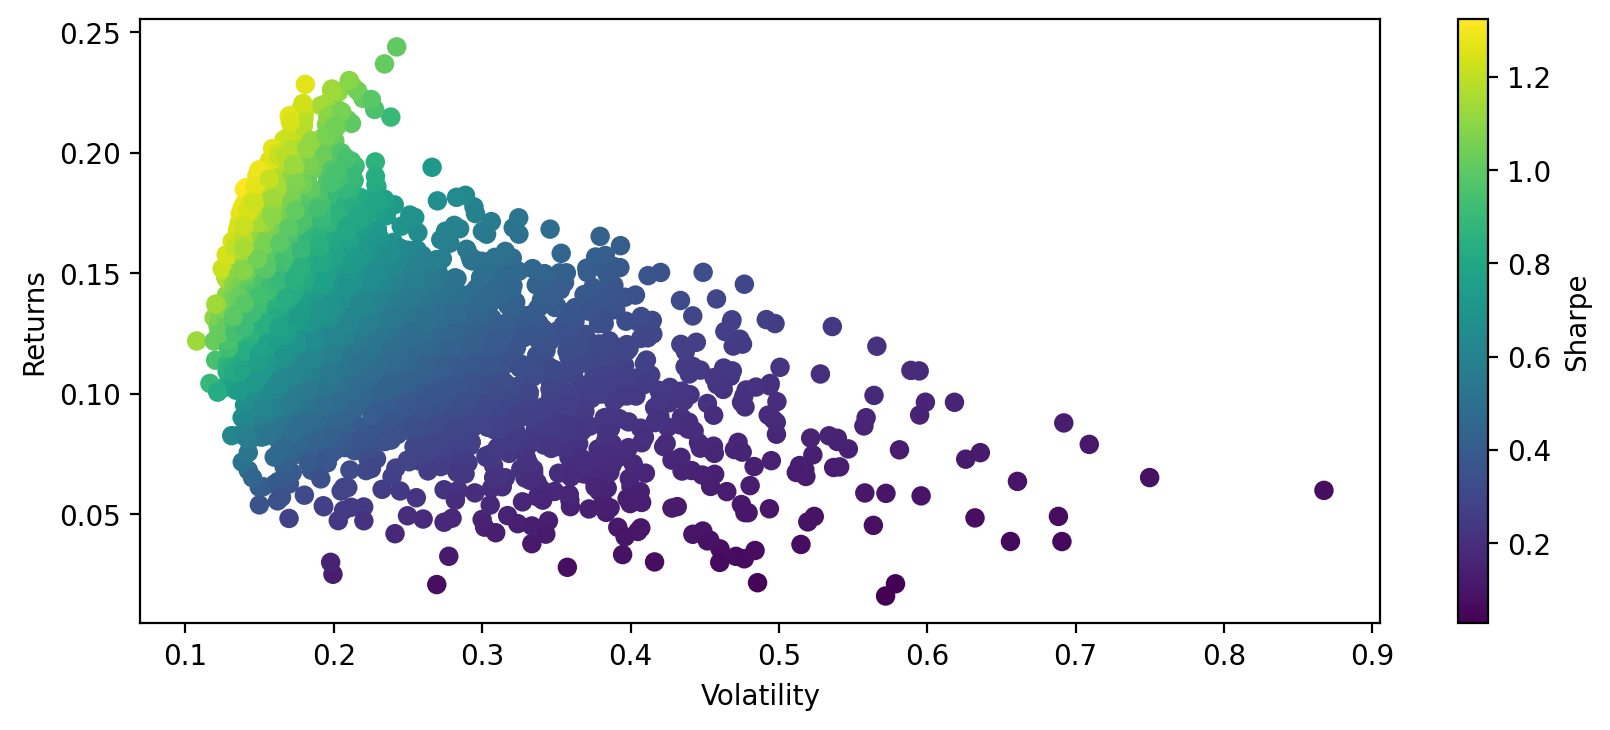

In [37]:
#Plloting Makowitz Bullet 
plt.figure(figsize=(10,4), dpi=200)
plt.scatter(mc_portfolio_vol, mc_portfolio_returns, c=mc_sharpe)
plt.colorbar(label='Sharpe')
plt.xlabel('Volatility')
plt.ylabel('Returns');

In [38]:
#High Return Weights---------------------------------------
weights_best_max_returns=np.round(mc_weights[np.argmax(mc_portfolio_returns)],2)*100
weights_best_max_sharpe=np.round(mc_weights[np.argmax(mc_sharpe)],2)*100
df_best_weights_max_returns=pd.DataFrame(weights_best_max_returns.reshape(1,num),columns=df.columns, index=['Weights  based on Max Returns %'])
df_best_weights_max_sharpe=pd.DataFrame(weights_best_max_sharpe.reshape(1,num),columns=df.columns, index=['Weights  based on Max Sharpe %'])
df_best_weights_max_returns.append(df_best_weights_max_sharpe.append(cum_return_final)).sort_values(by='Returns %', axis=1)

,GE,^VIX,^GSPC,AAPL,AMZN
Weights based on Max Returns %,3.000000,0.000000,6.000000,37.000000,54.000000
Weights based on Max Sharpe %,0.000000,10.000000,34.000000,28.000000,27.000000
Returns %,-16.438189,6.986026,299.080317,2187.388482,2310.956062


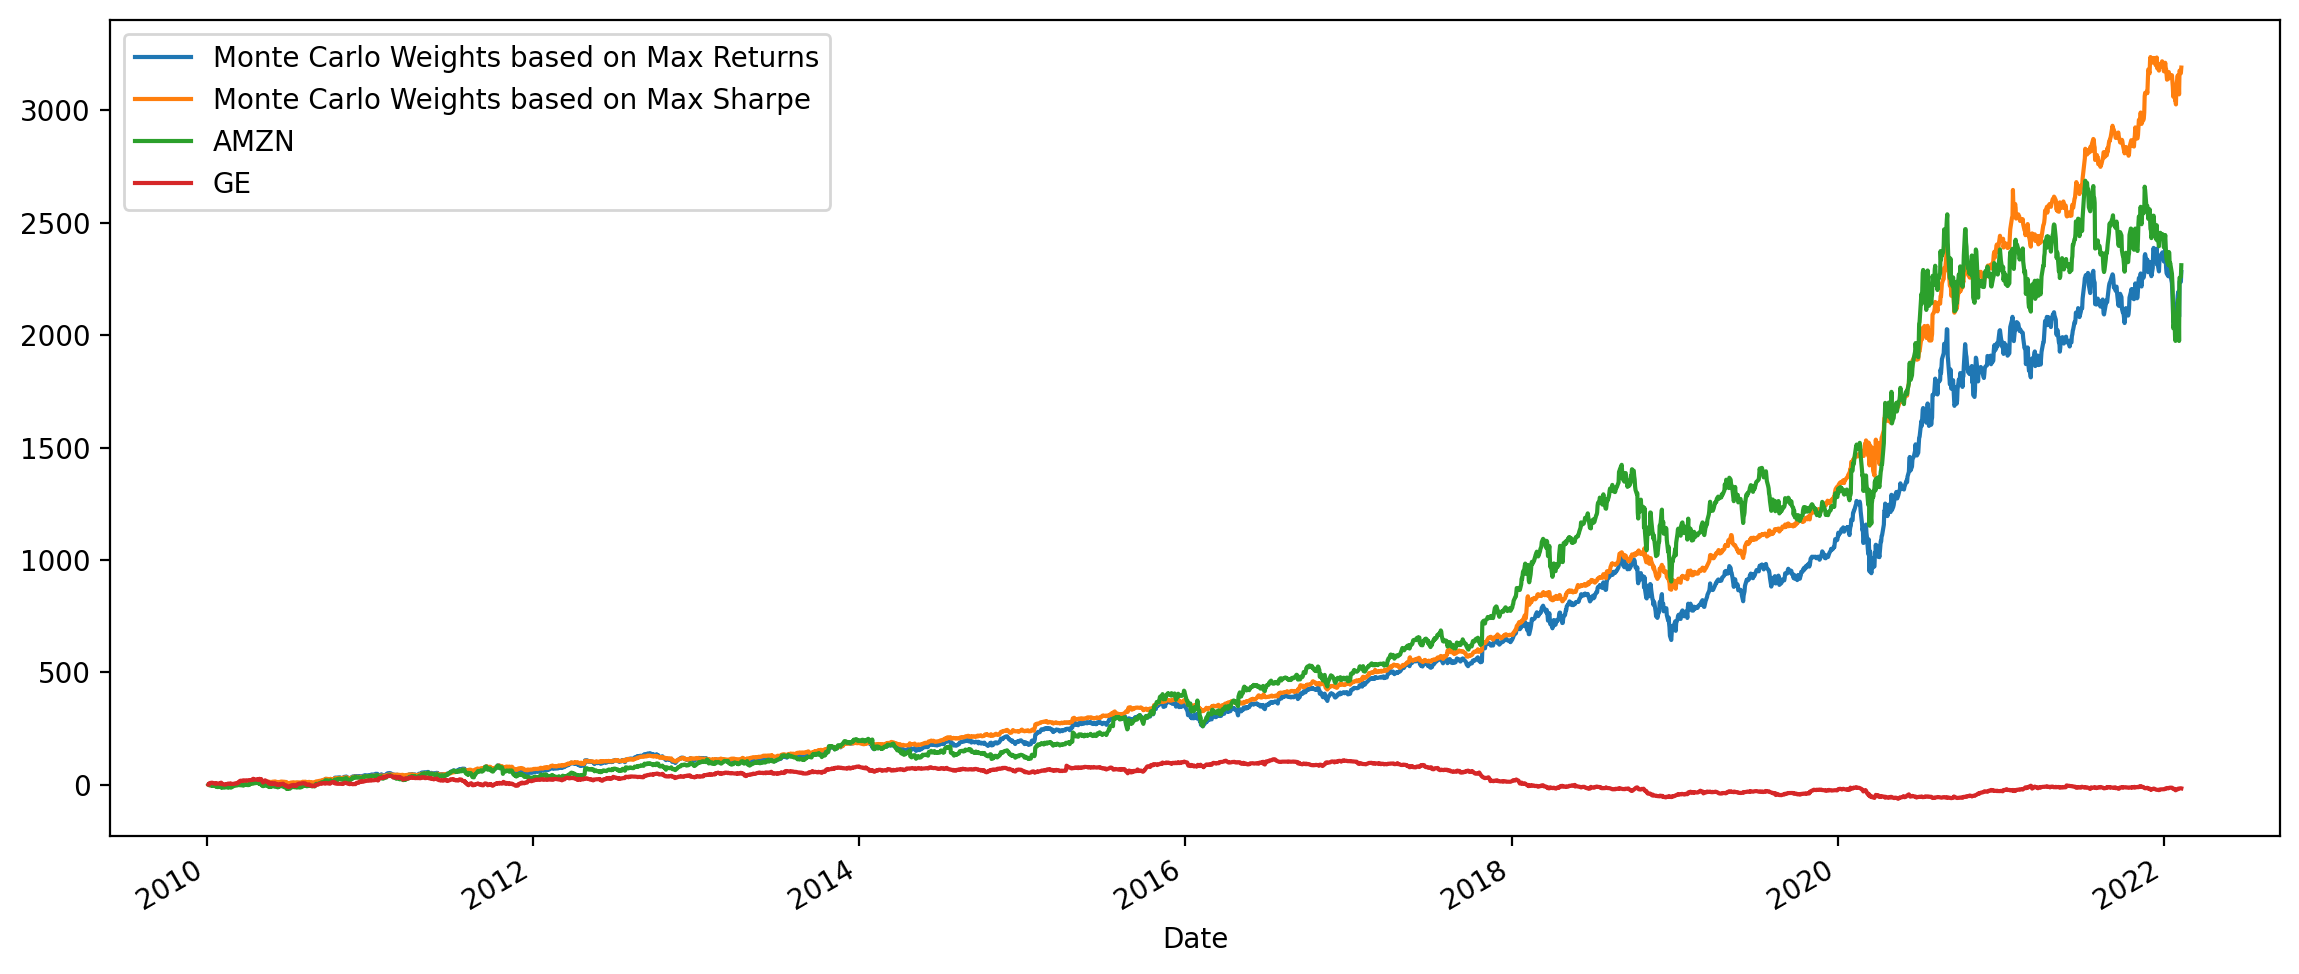

In [39]:
#Get the Return-------------------------------------------------------
monte_returns_max_returns=np.dot(mc_weights[np.argmax(mc_portfolio_returns)], returns.transpose())
monte_returns_max_sharpe=np.dot(mc_weights[np.argmax(mc_sharpe)], returns.transpose())
pd.DataFrame(monte_returns_max_returns)
pd.DataFrame(monte_returns_max_sharpe)
cum_monte_returns_max_returns=((1+monte_returns_max_returns).cumprod()-1)*100
cum_monte_returns_max_sharpe=((1+monte_returns_max_sharpe).cumprod()-1)*100
cum_monte_returns_max_returns=pd.Series(cum_monte_returns_max_returns, index=returns.index)
cum_monte_returns_max_sharpe=pd.Series(cum_monte_returns_max_sharpe, index=returns.index)
#-Plotting-------------------------------------------------------------
plt.figure(figsize=(14,6), dpi=200)
cum_monte_returns_max_returns.plot(label='Monte Carlo Weights based on Max Returns')
cum_monte_returns_max_sharpe.plot(label='Monte Carlo Weights based on Max Sharpe')
cum_returns[max_return].plot()
cum_returns[min_return].plot()
plt.legend();

# 4. Minimization Search Function (Highest Sharpe)

In [40]:
from scipy.optimize import minimize
def function(weights):
    return -1*(calc_returns(weights,log_returns)/calc_volatility(weights, log_returns_cov))

bounds=tuple ((0,1) for n in range(num))
constraints= ({'type':'eq', 'fun':lambda weights: np.sum(weights)-1})
equal_weights=num*[1/num]

In [41]:
weight_minimize=np.round(minimize(fun=function, x0=equal_weights, bounds=bounds, constraints=constraints)['x']*100)
weight_minimize_df=pd.DataFrame(weight_minimize.reshape(1,num), columns=df.columns, index=['Weights by Minimize Function %'])
weight_minimize_df.append(cum_return_final).sort_values(by='Returns %', axis=1)

,GE,^VIX,^GSPC,AAPL,AMZN
Weights by Minimize Function %,0.000000,10.000000,43.000000,26.000000,21.000000
Returns %,-16.438189,6.986026,299.080317,2187.388482,2310.956062


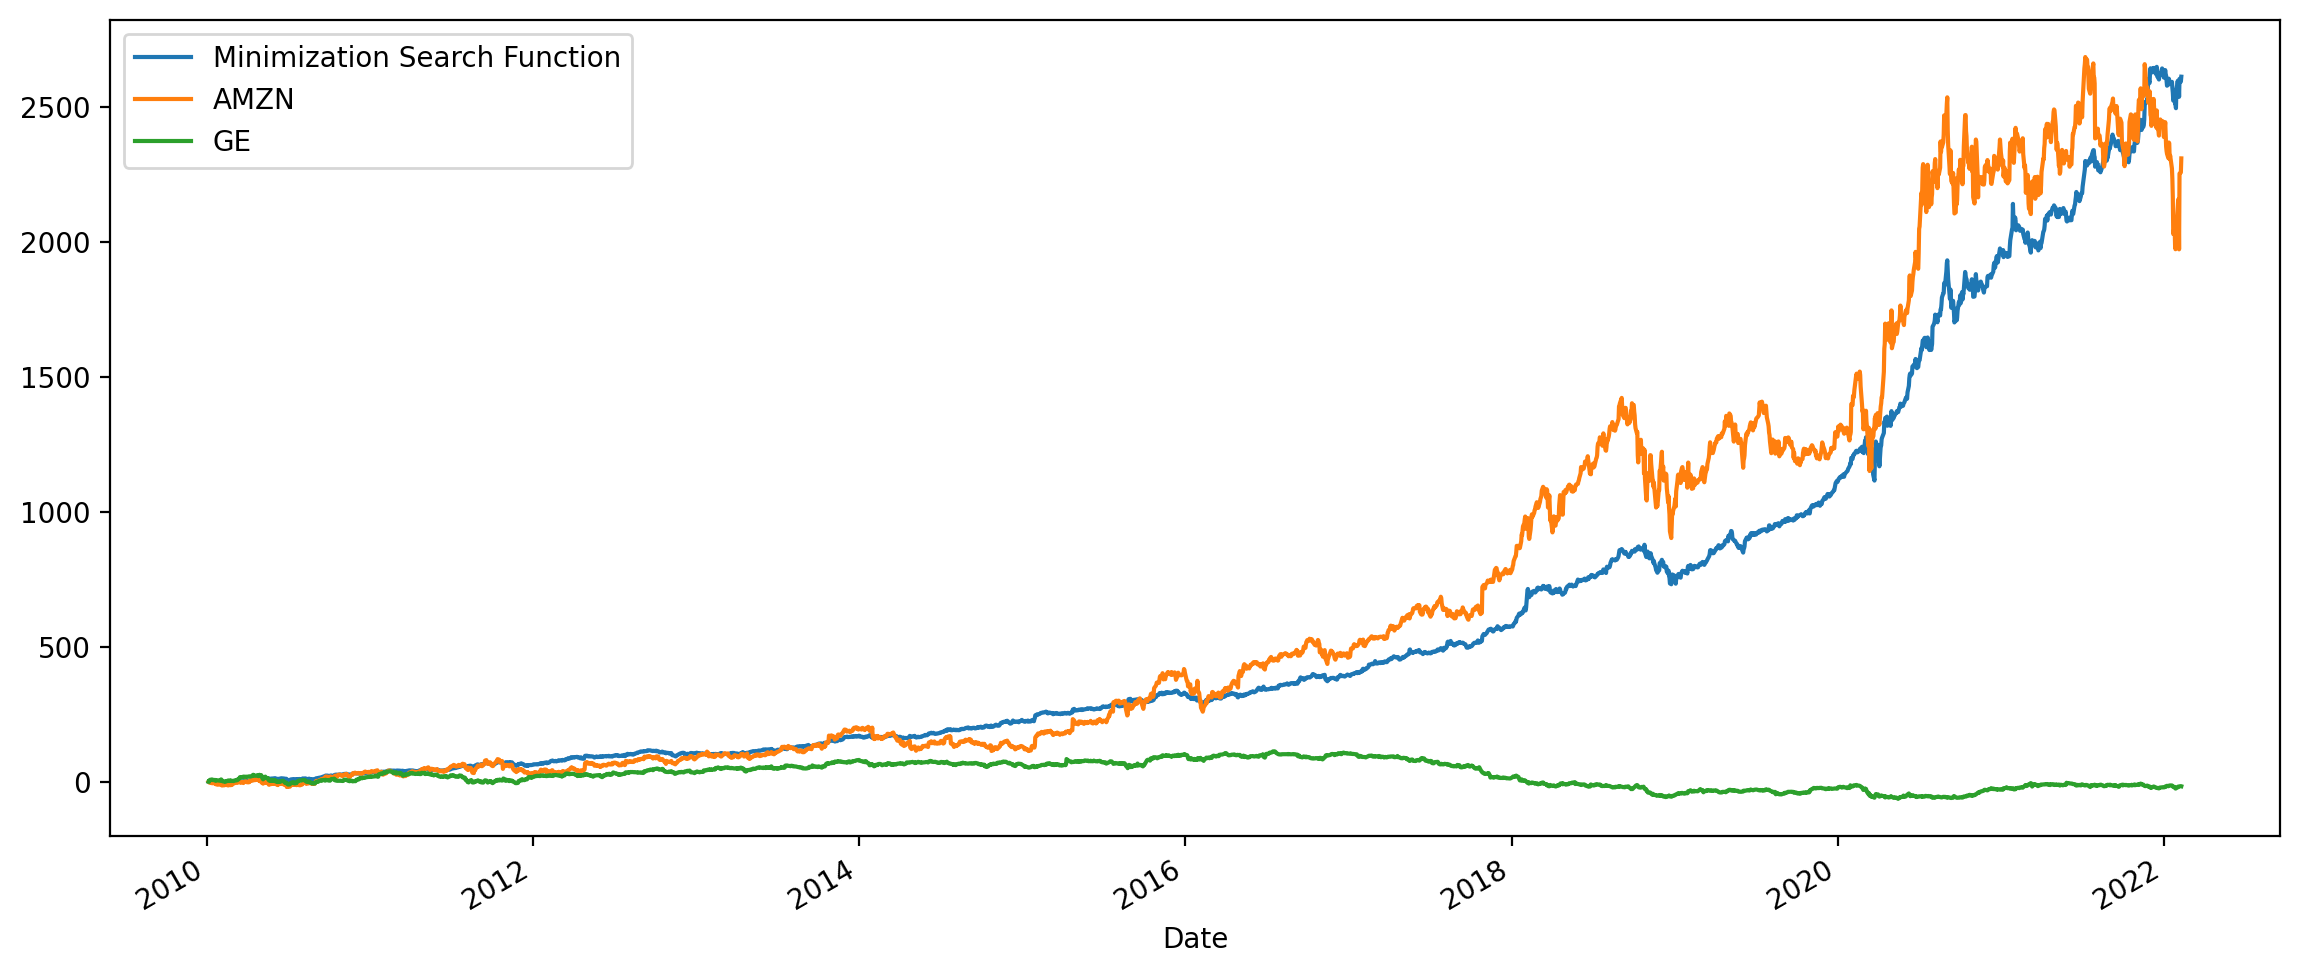

In [42]:
#Get the Return-------------------------------------------------------
minimization_return=np.dot(weight_minimize/100, returns.transpose())
pd.DataFrame(minimization_return)
cum_minimization_return=((1+minimization_return).cumprod()-1)*100
cum_minimization_return=pd.Series(cum_minimization_return, index=returns.index)
#-Plotting-------------------------------------------------------------
plt.figure(figsize=(14,6), dpi=200)
cum_minimization_return.plot(label='Minimization Search Function')
cum_returns[max_return].plot()
cum_returns[min_return].plot()
plt.legend();

# 5. Efficient Frontier (Arbitrary Volatility)

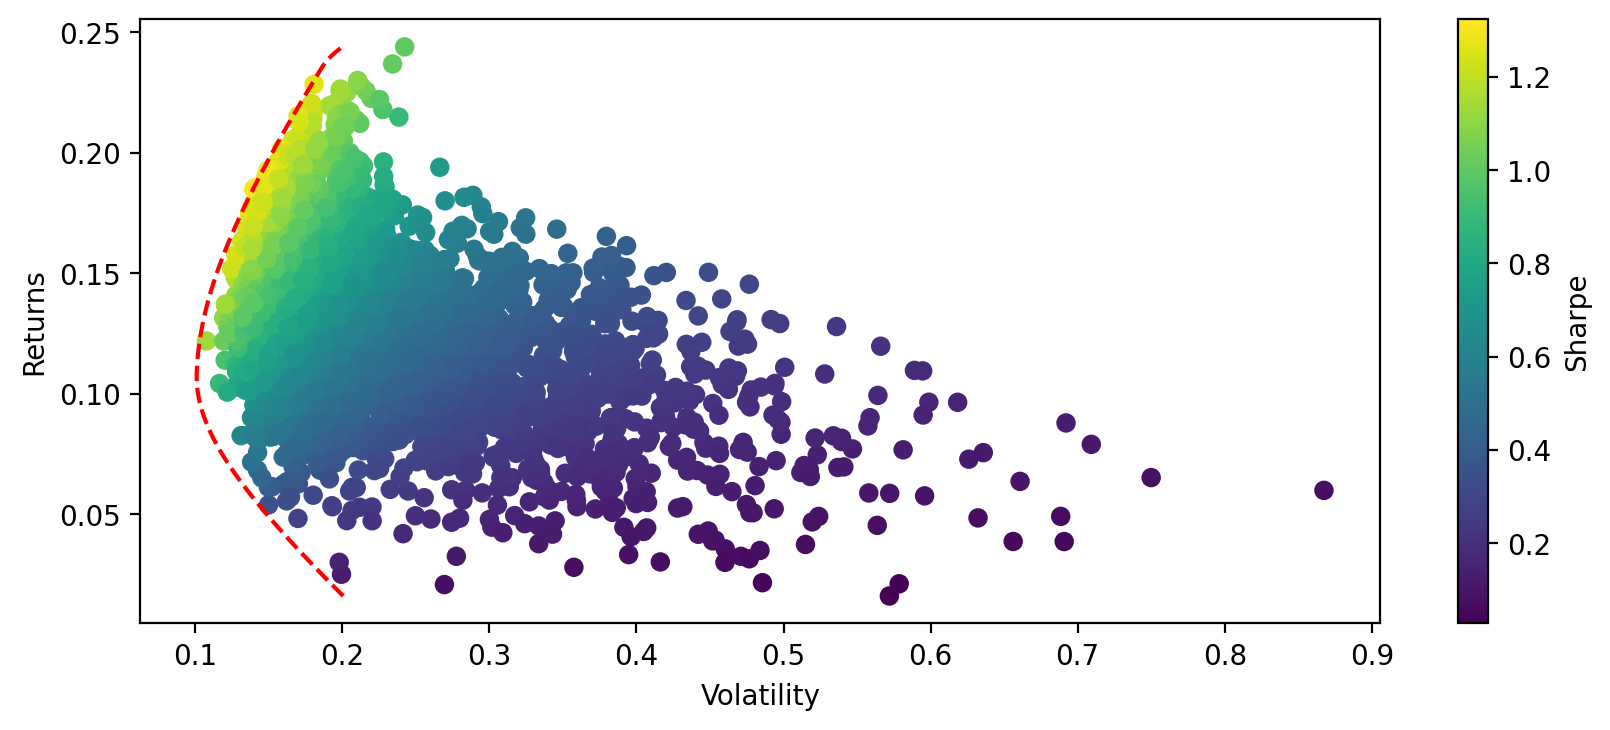

In [43]:
expected_return_range=np.linspace(np.min(mc_portfolio_returns),np.max(mc_portfolio_returns),200)
constraints= ({'type':'eq', 'fun':lambda weights: np.sum(weights)-1},
              {'type':'eq', 'fun':lambda weights: calc_returns(weights, log_returns)-possible_return})
def calc_volatility (weights):
    annulized_cov=np.dot(log_returns_cov*252, weights)
    vol=np.dot(weights.transpose(), annulized_cov)
    return np.sqrt(vol)
frontier_vol = []
portfolio_holding=[]

for possible_return in expected_return_range:
    result = minimize (calc_volatility, equal_weights, bounds=bounds, constraints=constraints)
    frontier_vol.append(result['fun'])
    portfolio_holding.append(result['x'])
    
#Plloting Makowitz Bullet 
plt.figure(figsize=(10,4), dpi=200)
plt.scatter(mc_portfolio_vol, mc_portfolio_returns, c=mc_sharpe)
plt.colorbar(label='Sharpe')
plt.xlabel('Volatility')
plt.ylabel('Returns');
plt.plot(frontier_vol, expected_return_range, color='red', ls='--');

In [44]:
#High Return Weights---------------------------------------
print('The lowest and Highest Volatility : ', np.round(np.min(frontier_vol),2), ',',np.round(np.max(frontier_vol),2))
art_vol=float(input('Enter your arbitrary Volatitility :'))
weight_arbit=portfolio_holding[(np.abs(np.array(frontier_vol)-art_vol)).argmin()]
weights_frontier_arbit_vol=np.round(weight_arbit,2)*100
df_frontier_arbit_vol=pd.DataFrame(weights_frontier_arbit_vol.reshape(1,num),columns=df.columns, index=['Weights  based on arbitrary Vol %'])
df_frontier_arbit_vol.append(cum_return_final).sort_values(by='Returns %', axis=1)

The lowest and Highest Volatility :  0.1 , 0.2
Enter your arbitrary Volatitility :0.15


,GE,^VIX,^GSPC,AAPL,AMZN
Weights based on arbitrary Vol %,0.000000,10.000000,26.000000,36.000000,27.000000
Returns %,-16.438189,6.986026,299.080317,2187.388482,2310.956062


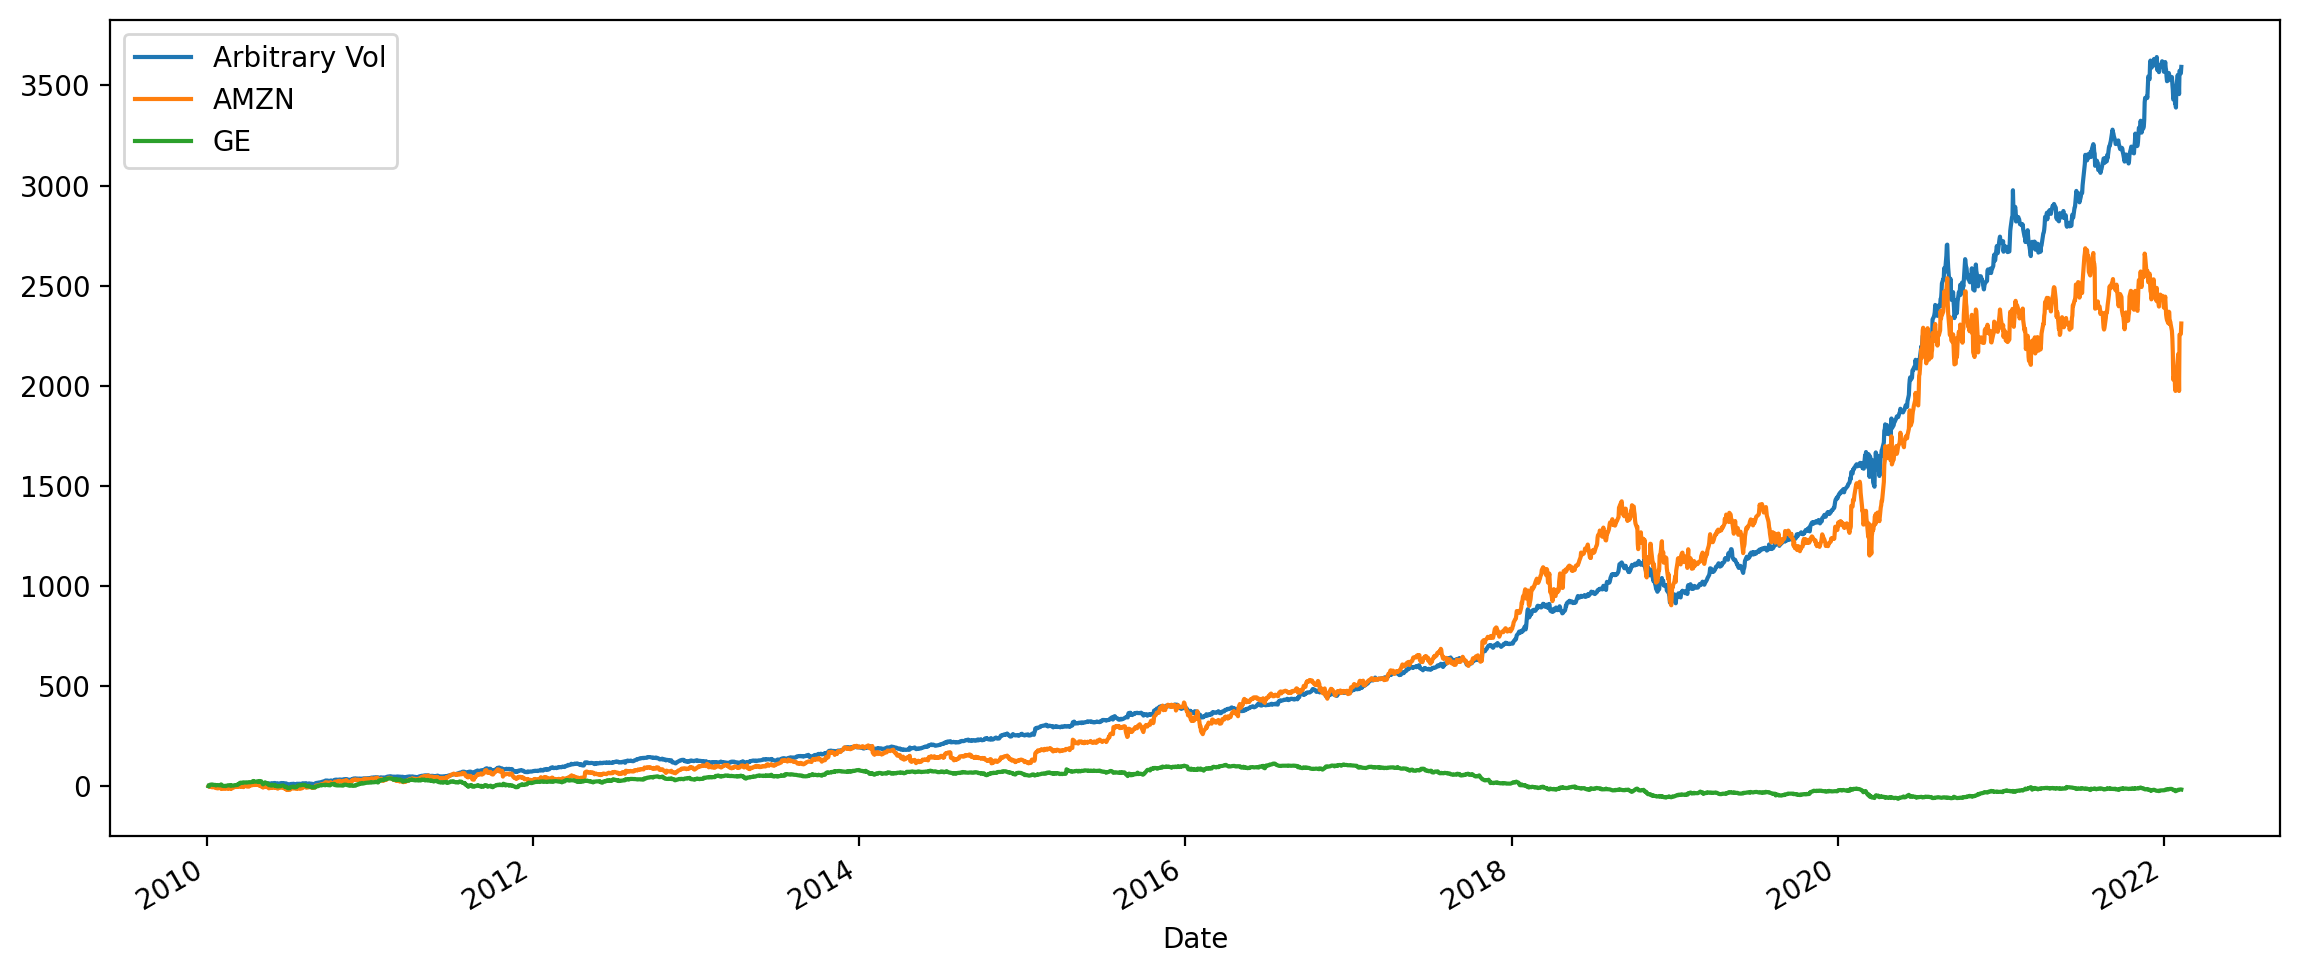

In [45]:
#Get the Return-------------------------------------------------------
frontier_return=np.dot(weight_arbit, returns.transpose())
pd.DataFrame(frontier_return)
cum_frontier_return=((1+frontier_return).cumprod()-1)*100
cum_frontier_return=pd.Series(cum_frontier_return, index=returns.index)
#-Plotting-------------------------------------------------------------
plt.figure(figsize=(14,6), dpi=200)
cum_frontier_return.plot(label='Arbitrary Vol')
cum_returns[max_return].plot()
cum_returns[min_return].plot()
plt.legend();

# Comparing Different Methods above

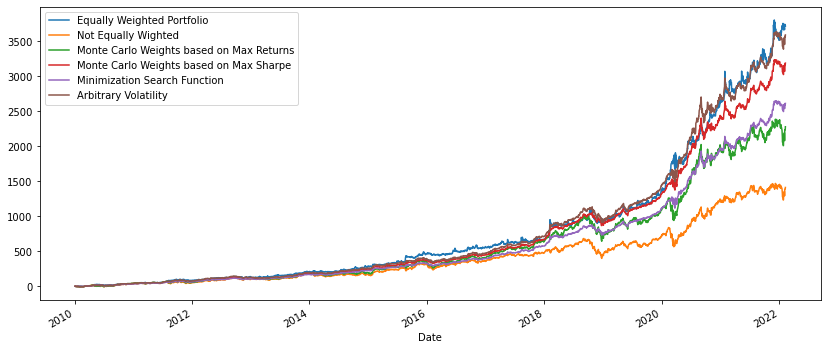

In [46]:
plt.figure(figsize=(14,6))
cum_equal_returns.plot(label='Equally Weighted Portfolio')
cum_notequal_returns.plot(label='Not Equally Wighted')
cum_monte_returns_max_returns.plot(label='Monte Carlo Weights based on Max Returns')
cum_monte_returns_max_sharpe.plot(label='Monte Carlo Weights based on Max Sharpe')
cum_minimization_return.plot(label='Minimization Search Function')
cum_frontier_return.plot(label='Arbitrary Volatility')
plt.legend();